In [1]:
import collections

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics

import analysis

%matplotlib inline

In [2]:
df = pd.read_table('p_vs_rank.tsv.gz')

no_self_df = df.query('train != 1 and uniprot_a != uniprot_b')
all_df = df.query('train != 1')

df.head()

,uniprot_a,uniprot_b,source_degree,target_degree,mean_degree,train,string,ht_2014,prior_empirical,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,Q96KB5,P61964,137.0,139.0,137.996377,1.0,1.0,0.0,0.384,0.002196,0.001484,0.116,0.136943,0.109186,0.068
1,O43251,Q9BTD8,64.0,42.0,51.845926,1.0,1.0,0.0,0.070,0.003078,0.000463,0.000,0.162162,0.034002,0.000
2,Q9H8Y8,Q14088,59.0,81.0,69.130312,1.0,1.0,0.0,0.090,0.003496,0.000784,0.000,0.134615,0.056892,0.002
3,Q96PP8,P48775,35.0,31.0,32.939338,1.0,1.0,0.0,0.018,0.005066,0.000306,0.012,0.000000,0.025617,1.000
4,P08670,Q96QU8,121.0,87.0,102.601170,1.0,1.0,0.0,0.260,0.001831,0.001022,0.254,0.063197,0.082953,0.922


### AUROC and correlation of prediction values with degree

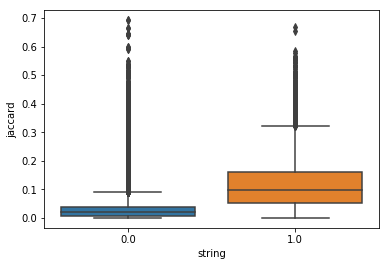

In [3]:
# Reconstruction

sns.boxplot(x='string', y='jaccard', data=no_self_df)

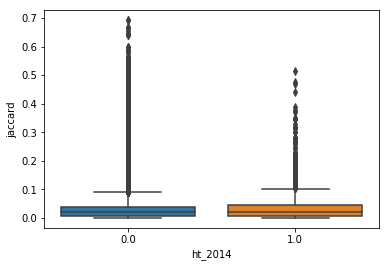

In [4]:
# Predicting systematic edges

sns.boxplot(x='ht_2014', y='jaccard', data=no_self_df)

In [5]:
records = (
    (feature,
     sklearn.metrics.roc_auc_score(all_df['string'], multiplier * all_df[feature]), 
     sklearn.metrics.roc_auc_score(no_self_df['string'], multiplier * no_self_df[feature]),
     sklearn.metrics.roc_auc_score(all_df['ht_2014'], multiplier * all_df[feature]), 
     sklearn.metrics.roc_auc_score(no_self_df['ht_2014'], multiplier * no_self_df[feature]))
    + scipy.stats.pearsonr(all_df['mean_degree'], all_df[feature])[:1]
    + scipy.stats.spearmanr(all_df['mean_degree'], all_df[feature])[:1]
    + scipy.stats.pearsonr(no_self_df['mean_degree'], no_self_df[feature])[:1]
    + scipy.stats.spearmanr(no_self_df['mean_degree'], no_self_df[feature])[:1]
    for feature, multiplier in {'prior_empirical': 1, 'rwr': 1, 'mean_rwr': 1, 'p_rwr': -1, 
                                'jaccard': 1, 'mean_jaccard': 1, 'p_jaccard': -1,
                               }.items()
)
info_df = pd.DataFrame.from_records(records, columns=['feature', 'recon_auc_all', 'recon_auc_no_loop', 
                                                      'syst_auc_all', 'syst_auc_no_loop', 
                                                      'pearson_all', 'spearman_all', 
                                                      'pearson_no_loop', 'spearman_no_loop', ])

info_df

,feature,recon_auc_all,recon_auc_no_loop,syst_auc_all,syst_auc_no_loop,pearson_all,spearman_all,pearson_no_loop,spearman_no_loop
0,prior_empirical,0.778095,0.778037,0.478536,0.491210,0.888897,0.912437,0.889194,0.912673
1,rwr,0.939805,0.940521,0.606185,0.569983,0.040083,0.640101,0.364910,0.641041
2,mean_rwr,0.722243,0.722793,0.525803,0.482069,0.049634,0.682058,0.631295,0.683068
3,p_rwr,0.896303,0.896422,0.626897,0.615256,0.094989,0.095139,0.094529,0.094760
4,jaccard,0.868286,0.868947,0.566956,0.527081,0.525444,0.675295,0.653109,0.676305
5,mean_jaccard,0.790260,0.790863,0.527886,0.484350,0.589236,0.920767,0.938039,0.922178
6,p_jaccard,0.840163,0.840080,0.522244,0.542108,-0.249165,-0.326593,-0.249496,-0.326511


### Plots

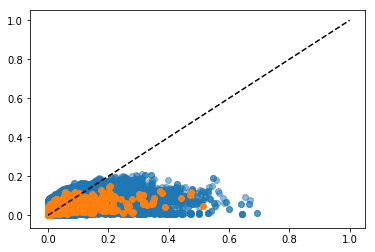

In [6]:
plt.scatter('jaccard', 'mean_jaccard', data=no_self_df.query('ht_2014 == 0'), alpha=0.5)
plt.scatter('jaccard', 'mean_jaccard', data=no_self_df.query('ht_2014 == 1'))
plt.plot([0,1], [0,1], linestyle='--', color='black')

Text(0, 0.5, 'Mean Jaccard on permuted networks')

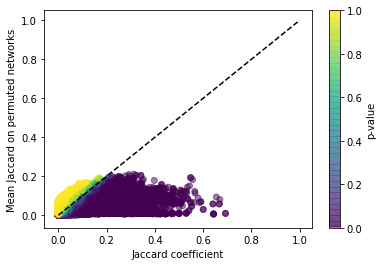

In [7]:
sc = plt.scatter('jaccard', 'mean_jaccard', c='p_jaccard', data=no_self_df, alpha=0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('p-value')
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.xlabel('Jaccard coefficient')
plt.ylabel('Mean Jaccard on permuted networks')